# Automatic Essay Grading

This notebook contains the analysis and model building steps taken to build a model that automatically grades essays.

- Stephen Turban {turban@college.harvard.edu}
- Noah Yonack {noahyonack@college.harvard.edu}

A lot of this work was done via "milestones" submitted throughout the past month. This notebook consolidates only the important parts of each milestone. For instance, in milestone #3, we looked at essay score as a function of both the number of unique words per essay and the number of total words per essay. We found that the number of unique words is highly correlated with the number of total words per essay. For that reason, it's not a very valuable feature, and we choose not to include all of the scatterplots in this notebook.

In [46]:
import matplotlib
import numpy as np
import scipy.sparse
import pandas as pd
import sklearn.svm as svm
import matplotlib.pyplot as plt
from scipy.stats import mode, spearmanr, pearsonr
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import KFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
%matplotlib inline

Let's start by reading in our data. By examining the dataset, we see that the important columns seem to be the *essay_set*, *essay*, and *domain1_score*. Let's read in just those columns.

In [4]:
# read in our data 
essay_df = pd.read_csv("datasets/training_set_rel3.tsv", delimiter = "\t", usecols=["essay_set", "rater1_domain1", "rater2_domain1", "essay", "domain1_score"])
print "Shape of data:", essay_df.shape
essay_df.head(4)

Shape of data: (12976, 5)


essay_set                                              essay  \
0          1  Dear local newspaper, I think effects computer...   
1          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3          1  Dear Local Newspaper, @CAPS1 I have found that...   

   rater1_domain1  rater2_domain1  domain1_score  
0               4               4              8  
1               5               4              9  
2               4               3              7  
3               5               5             10

# Preliminary Data Exploration

In this section, we do basic exploration of our dataset. Much of this is taken from Milestone #3.

Notice that each essay can come from 1 of 8 different sets. Is each essay set represented equally?

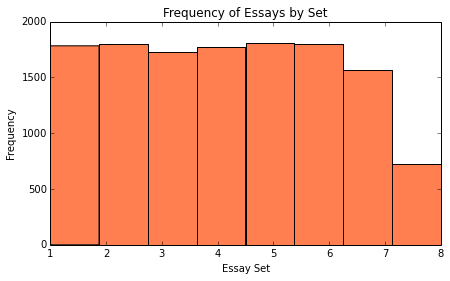

In [5]:
plt.figure(figsize=(7, 4))
plt.title("Frequency of Essays by Set")
plt.xlabel("Essay Set")
plt.ylabel("Frequency")
_ = plt.hist(essay_df["essay_set"], bins=8, color="coral")

There seems to be a fairly equal representation of each essay set, besides set 8.

How about the distribution of essay scores?

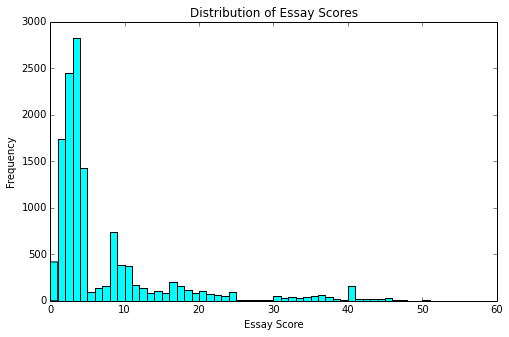

In [6]:
plt.figure(figsize=(8, 5))
plt.title("Distribution of Essay Scores")
plt.xlabel("Essay Score")
plt.ylabel("Frequency")
_ = plt.hist(essay_df["domain1_score"], bins=60, color='cyan')

Notice the multiple local modes in the plot above. This tips us off that not all essay sets are graded on the same range (which is indeed the case). This likely means that using essay set as a predictor in our model will help us narrow down the range of our predicted response variable.

Let's now look at the relationship between essay length and score.

In [7]:
essay_df["essay_len"] = map(lambda essay: len(essay.split(" ")), essay_df["essay"])
essay_df.head(2)

essay_set                                              essay  \
0          1  Dear local newspaper, I think effects computer...   
1          1  Dear @CAPS1 @CAPS2, I believe that using compu...   

   rater1_domain1  rater2_domain1  domain1_score  essay_len  
0               4               4              8        338  
1               5               4              9        419

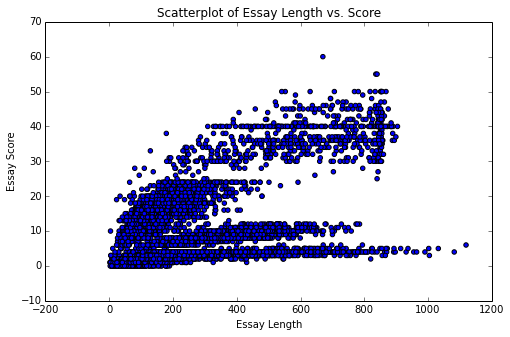

In [8]:
plt.figure(figsize=(8,5))
plt.title("Scatterplot of Essay Length vs. Score")
plt.xlabel("Essay Length")
plt.ylabel("Essay Score")
_ = plt.scatter(essay_df["essay_len"], essay_df["domain1_score"])

Notice the multiple "fingers" in the scatterplot above. Each one likely belongs to essays from the same set. These might also indicate some amount of correlation between essay length and score — let's explore this at the set level to see if using essay length will be a valuable feature in our model.

Spearman's rho of length vs. score for set 1: 0.782766031026
Spearman's rho of length vs. score for set 2: 0.654913956988
Spearman's rho of length vs. score for set 3: 0.715942185421
Spearman's rho of length vs. score for set 4: 0.758312293196
Spearman's rho of length vs. score for set 5: 0.825339975986
Spearman's rho of length vs. score for set 6: 0.685804387747
Spearman's rho of length vs. score for set 7: 0.679931285772
Spearman's rho of length vs. score for set 8: 0.441023995554


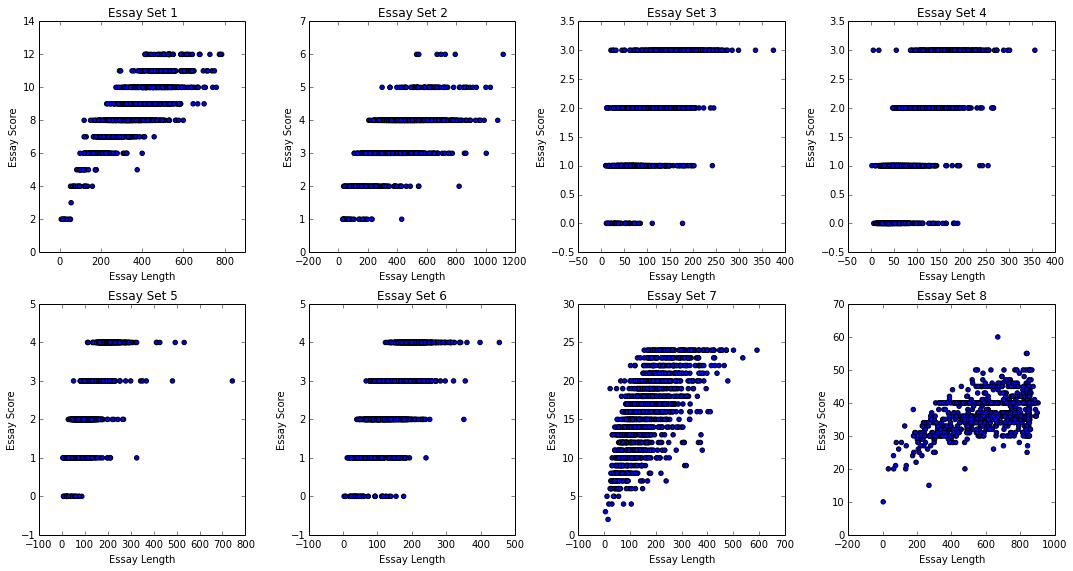

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

for essay_set_id in essay_df["essay_set"].unique():
    essays_by_set = essay_df[essay_df["essay_set"] == essay_set_id]
    
    if essay_set_id > 4:
        col = essay_set_id - 5
    else:
        col = essay_set_id - 1
    
    ax[essay_set_id / 5, col].set_title("Essay Set {0}".format(essay_set_id))
    ax[essay_set_id / 5, col].set_xlabel("Essay Length")
    ax[essay_set_id / 5, col].set_ylabel("Essay Score")
    ax[essay_set_id / 5, col].scatter(essays_by_set["essay_len"], essays_by_set["domain1_score"])
    print "Spearman's rho of length vs. score for set {0}: {1}".format(essay_set_id, spearmanr(essays_by_set["essay_len"], essays_by_set["domain1_score"])[0])

plt.tight_layout()

As we can see from the scatterplots and correlation coefficients above, length is moderately, and, in some cases, strongly correlated with essay meaning that it will likely be a very valuable predictor for our model.

In [10]:
essay_df["n_unique_words"] = map(lambda essay: len(set(map(lambda word: word.lower(), essay.split(" ")))), essay_df["essay"])
essay_df.head(3)

essay_set                                              essay  \
0          1  Dear local newspaper, I think effects computer...   
1          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   

   rater1_domain1  rater2_domain1  domain1_score  essay_len  n_unique_words  
0               4               4              8        338             177  
1               5               4              9        419             207  
2               4               3              7        279             158

In [11]:
spearmanr(essay_df["n_unique_words"], essay_df["essay_len"])[0]

0.98362530226685208

We might also imagine that the number of unique words per essay is somewhat related to the score of that essay (e.g. it might indicate a large vocabulary). That said, it's *very* strongly correlated with essay length, so we only have to use one of the two in our model. For now, let's stick with essay length.

Let's also look at the inter-annotator agreement, which is often used as a proxy for how difficult the task is for a human being. 

In [12]:
print "Inter-annotator agreement for all data:", pearsonr(essay_df["rater1_domain1"], essay_df["rater2_domain1"])[0]

for essay_set_id in essay_df["essay_set"].unique():
    essays_by_set = essay_df[essay_df["essay_set"] == essay_set_id]
    corr = pearsonr(essays_by_set["rater1_domain1"], essays_by_set["rater2_domain1"])[0]
    print "Inter-annotator agreement for set {0}: {1}".format(essay_set_id, corr)

Inter-annotator agreement for all data: 0.969326153232
Inter-annotator agreement for set 1: 0.721326713194
Inter-annotator agreement for set 2: 0.814428480539
Inter-annotator agreement for set 3: 0.77081551949
Inter-annotator agreement for set 4: 0.85094057661
Inter-annotator agreement for set 5: 0.752701028057
Inter-annotator agreement for set 6: 0.776538846688
Inter-annotator agreement for set 7: 0.722006313615
Inter-annotator agreement for set 8: 0.63060880576


In general, it looks as if the inter-annotator agreement is very high, though certainly not 1 (especially for essay sets 7 and 8). This indicates that essays are difficult to grade, meaning that two expert raters can occasionally come up with different grades. 

# Model Building

In this section, we build our model, including a baseline which we can evaluate against. Some, but not all, of this code is taken from milestone #4.

This notebook only includes the building and tuning of a l1-regularized linear model. We've already experimented in milestone #4 with an l2-regularized linear model, as well as a Support Vector Regressor, and we've found that the l1-regularized linear model tends to yield the best predictions.

As part of our feature selection, let's also include the prompt (which we will vectorize along with the essay text). Perhaps knowing the prompt text will help us determine a grade (for instance, we might imagine that using words from the prompt in an essay means that the essay is on-topic and will thus receive a better grade).

In [13]:
prompts_df = pd.read_csv("prompts.csv", names=["essay_set", "prompt_text"], skiprows=1)
prompts_df.head(2)

essay_set                                        prompt_text
0          1  More and more people use computers, but not ev...
1          2  All of us can think of a book that we hope non...

Joining this with our essay dataframe so that all of our data is in one place:

In [14]:
essay_df = essay_df.join(prompts_df.set_index("essay_set"), on="essay_set", how="inner")
essay_df.head(2)

essay_set                                              essay  \
0          1  Dear local newspaper, I think effects computer...   
1          1  Dear @CAPS1 @CAPS2, I believe that using compu...   

   rater1_domain1  rater2_domain1  domain1_score  essay_len  n_unique_words  \
0               4               4              8        338             177   
1               5               4              9        419             207   

                                         prompt_text  
0  More and more people use computers, but not ev...  
1  More and more people use computers, but not ev...

Let's begin by vectorizing our essays and prompts into actual features. For this vectorization, we'll use TF-IDF.

In [15]:
def get_TFIDF(n_grams=1):
    '''
    Returns a TFIDF matrix for the essay_df matrix given a certain number of n_grams.
    '''
    vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, n_grams))
    corpus = essay_df["essay"].values + essay_df["prompt_text"].values
    return vectorizer.fit_transform(corpus)

In [16]:
# convert essay length and set into sparse datatypes as well
sparse_essay_length = scipy.sparse.csc_matrix(essay_df["essay_len"]).transpose()
sparse_essay_set = scipy.sparse.csc_matrix(essay_df["essay_set"]).transpose()

In [17]:
def tune_lasso(X, y, alphas=[.0001, .001, .01 , 1], n_folds=2):
    '''
    Tunes the hyperparamter of a l1-regularized linear model using
    `n_folds` CV
    '''
    lasso_alpha_list = alphas
    lasso_spearman_value = []

    for alpha in lasso_alpha_list: 
        lasso_spearman_temp = []

        print "Testing alpha = {0}".format(alpha)

        # gives us the different folds of our data to test against
        folds = KFold(X.shape[0], n_folds=2, shuffle=True)

        for train_indices, test_indices in folds:
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            lasso = Lasso(alpha=alpha)

            # fit on the training data 
            lasso.fit(X_train, y_train)

            spearman_r = scipy.stats.spearmanr(lasso.predict(X_test), y_test)
            lasso_spearman_temp.append(spearman_r[0])

        lasso_spearman_value.append(np.mean(lasso_spearman_temp))
    
    return alphas, lasso_spearman_value

In [18]:
def plot_score(x, y, title, xlabel, ylabel, vlabel, pic_title):
    '''
    Plots the accuracy of a model (likely spearman's rho) against
    the various regularization parameters used in the tuning process
    '''
    plt.figure(figsize=(8, 6))
    plt.title(title, fontsize=12)
    plt.semilogx(x, y)

    best_index = np.argmax(np.array(y))
    plt.axvline(x[best_index], c='r', label=vlabel.format(y[best_index]))

    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)0:.3f
    plt.legend()
    plt.show()

Let's start with a baseline model, which uses just the vectorized essay + prompt, as well as the length and the essay set.

### Baseline Model

In [20]:
X = scipy.sparse.hstack([get_TFIDF(), sparse_essay_length, sparse_essay_set], format="csr")
alphas_baseline, spearmans_basline = tune_lasso(X, essay_df["domain1_score"])

Testing alpha = 0.0001


/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.87357048650476687, 0.87984341281840761, 0.84840183987441664, 0.68505957626653546]


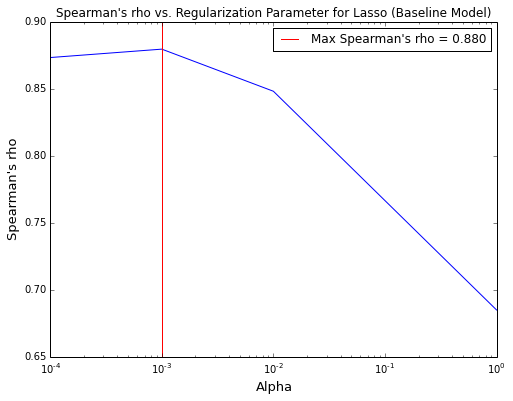

In [21]:
print "Alphas:", alphas_baseline
print "Spearman:", spearmans_basline
plot_score(alphas_baseline, spearmans_basline, "Spearman's rho vs. Regularization Parameter for Lasso (Baseline Model)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "baseline")

Off the bat, our baseline model is really good, yielding a Spearman's rho of 0.87. This will be hard to beat.

Let's try using Latent Semantic Analysis (LSA), which performs similarly to PCA, to reduce the dimensionality of our data.

In [22]:
def fit_model_using_lsa(n_components=100, n_grams=1):
    lsa = TruncatedSVD(n_components=n_components)
    reduced_vector = lsa.fit_transform(get_TFIDF(n_grams=n_grams))

    X = scipy.sparse.hstack([reduced_vector, sparse_essay_length, sparse_essay_set], format="csr")
    alphas, spearmans = tune_lasso(X, essay_df["domain1_score"])
    return alphas, spearmans

### LSA on Unigram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


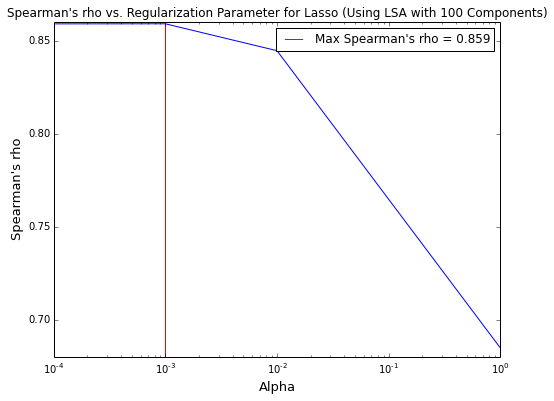

In [23]:
alphas_1, spearmans_1 = fit_model_using_lsa(n_grams=1)
plot_score(alphas_1, spearmans_1, "Spearman's rho vs. Regularization Parameter for Lasso (Using LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "LSA(100)")

Notice that the accuracy of our model is actually worse than the baseline. This might be because we lose some signal in the data after performing LSA. Though LSA intends to cluster data by concept (i.e. words similar in meaning get placed in the same component), we may be clustering poorly due to the fact that we only have unigrams in our model. It's likely hard to figure out which words have similar meaning when we have no context to the word.

### LSA on Bigram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


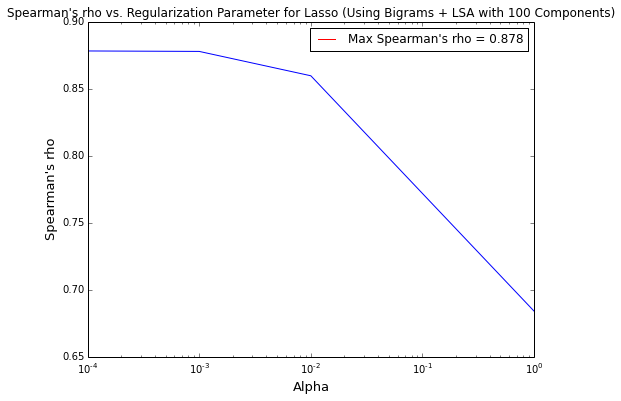

In [24]:
alphas_2, spearmans_2 = fit_model_using_lsa(n_grams=2)
plot_score(alphas_2, spearmans_2, "Spearman's rho vs. Regularization Parameter for Lasso (Using Bigrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Bigrams + LSA(100)")

### LSA on Trigram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


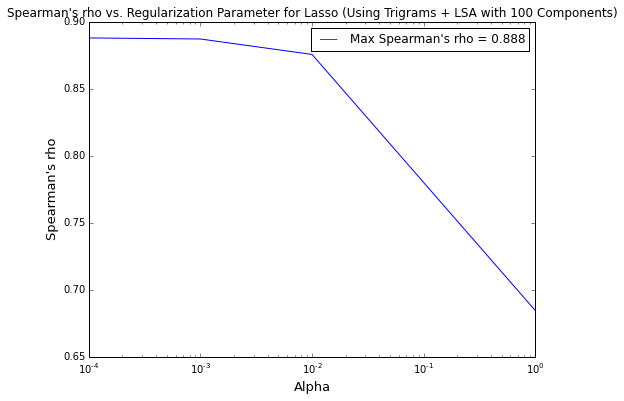

In [25]:
alphas_3, spearmans_3 = fit_model_using_lsa(n_grams=3)
plot_score(alphas_3, spearmans_3, "Spearman's rho vs. Regularization Parameter for Lasso (Using Trigrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Trigrams + LSA(100)")

### LSA on Quadgram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


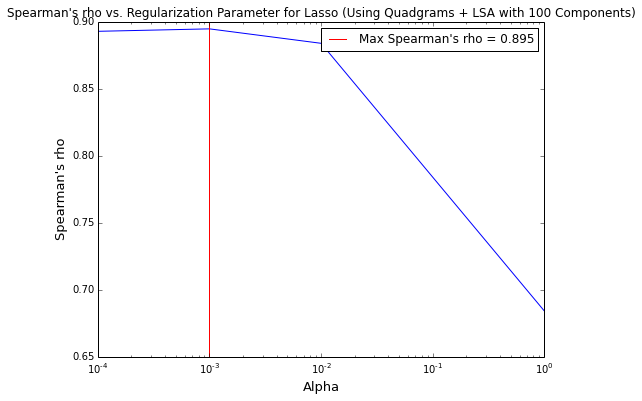

In [26]:
alphas_4, spearmans_4 = fit_model_using_lsa(n_grams=4)
plot_score(alphas_4, spearmans_4, "Spearman's rho vs. Regularization Parameter for Lasso (Using Quadgrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Quadgrams + LSA(100)")

### LSA on 7-Gram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


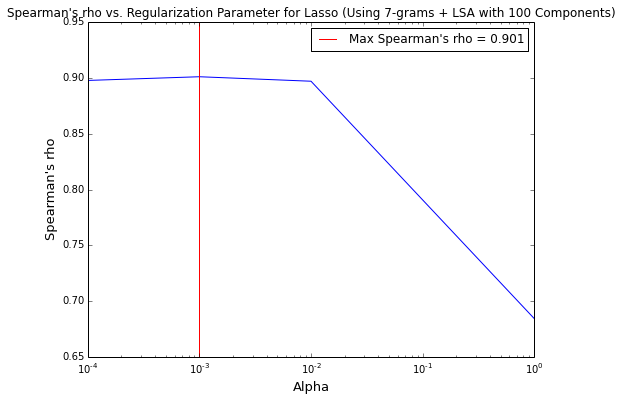

In [27]:
alphas_7, spearmans_7 = fit_model_using_lsa(n_grams=7)
plot_score(alphas_7, spearmans_7, "Spearman's rho vs. Regularization Parameter for Lasso (Using 7-grams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "7-grams + LSA(100)")

### LSA on 15-Gram Features

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1


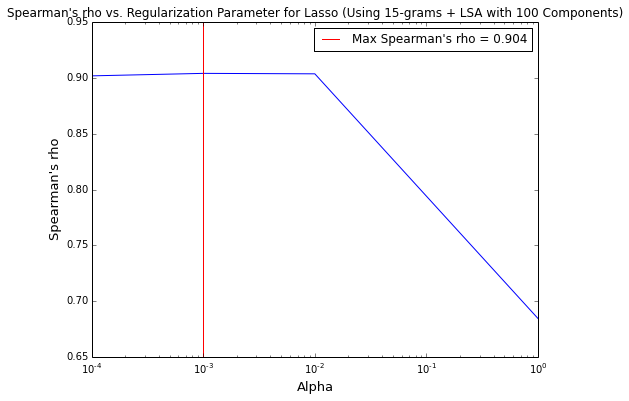

In [28]:
alphas_15, spearmans_15 = fit_model_using_lsa(n_grams=15)
plot_score(alphas_15, spearmans_15, "Spearman's rho vs. Regularization Parameter for Lasso (Using 15-grams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "15-grams + LSA(100)")

Best accuracy: 0.90410655401


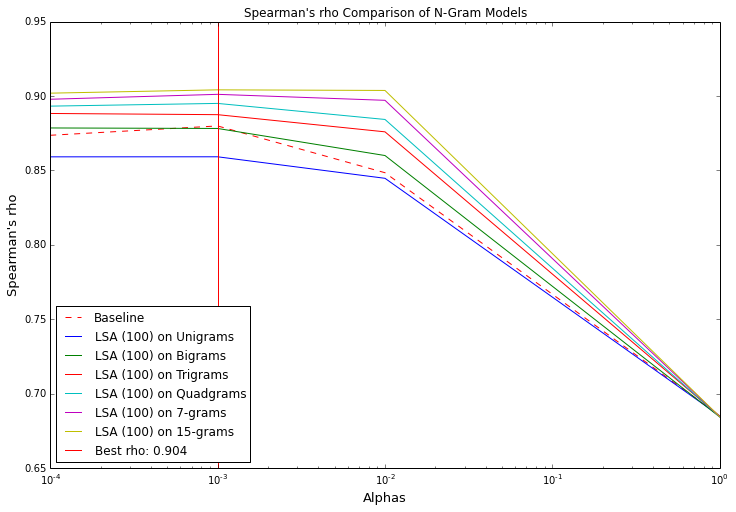

In [42]:
plt.figure(figsize=(12, 8))
plt.title("Spearman's rho Comparison of N-Gram Models", fontsize=12)

plt.semilogx(alphas_baseline, spearmans_basline, "r--", label="Baseline")
plt.semilogx(alphas_1, spearmans_1, label="LSA (100) on Unigrams")
plt.semilogx(alphas_2, spearmans_2, label="LSA (100) on Bigrams")
plt.semilogx(alphas_3, spearmans_3, label="LSA (100) on Trigrams")
plt.semilogx(alphas_4, spearmans_4, label="LSA (100) on Quadgrams")
plt.semilogx(alphas_7, spearmans_7, label="LSA (100) on 7-grams")
plt.semilogx(alphas_15, spearmans_15, label="LSA (100) on 15-grams")

best_index = np.argmax(np.array(spearmans_15))
best_value = spearmans_15[best_index]

print "Best accuracy:", best_value
plt.axvline(alphas_15[best_index], c='r', label="Best rho: {0:.3f}".format(spearmans_15[best_index]))

plt.xlabel("Alphas", fontsize=13)
plt.ylabel("Spearman's rho", fontsize=13)
plt.legend(loc="lower left")
plt.show()

As we can see from the above comparison, the model which uses 15-grams and LSA with 100 components is the winner, giving us a Spearman's rho of 0.904. This rivals even the professional approaches by professionals, many of whom have employed nueral nets on this exact same dataset [[example]](https://da352.user.srcf.net/public_uploads/acl2016.pdf).

We might imagine that we can continue improving accuracy by increasing the size of our n-grams. This is likely not the case, though, because we'll eventually use a size (likely not much bigger than 15) in which grams only exist once in the entire corpus, meaning they'll have no predictive power.